In [2]:
import datetime as dt
import glob
import netCDF4 as nc
import numpy as np
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
from gsw import sigma0
import numpy.ma as ma

import time
import yaml

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = '/home1/datahome/mlejeune/cartopy_shapefiles'



In [3]:
d_test = xr.open_dataset("/home/datawork-lops-bluecloud/osnet/data_out/bootstrap/OsNet_test_Nordic_Sea/test_ds.nc")
d_train = xr.open_dataset("/home/datawork-lops-bluecloud/osnet/data_out/bootstrap/OsNet_test_Nordic_Sea/train_ds.nc")

In [4]:
d_full = xr.open_dataset("/home/datawork-lops-bluecloud/osnet/data_out/bootstrap/OsNet_test_Nordic_Sea/full_ds.nc")

### Glorys12

In [5]:
x_glo = xr.open_dataset('/home1/datahome/mlejeune/assets/GLORYS_interp/GLORYS_Interp_Final.nc')
x_glo = x_glo.where(x_glo.depth<1001,drop = True)

In [6]:
#Compute GLORYS RMSE weighted by depth levels
#RMSE function
def rmse_from_ae(ae):
    return np.sqrt(((ae) ** 2).mean(axis=0))

rmse_T = rmse_from_ae(x_glo['ae_to'])
rmse_S = rmse_from_ae(x_glo['ae_so'])
rmse_SIG = rmse_from_ae(x_glo['ae_SIG'])
x_glo = x_glo.assign(variables={"rmse_T": (('depth'), rmse_T.data)})
x_glo = x_glo.assign(variables={"rmse_S": (('depth'), rmse_S.data)})
x_glo = x_glo.assign(variables={"rmse_SIG": (('depth'), rmse_SIG.data)})

#Creation of delta z (shift and add a 46m)
p = x_glo.depth
dz = np.ones(len(p))
for n in np.arange(0,len(p)-1):
    dz[n+1] = p[n+1]-p[n]
dzs = list(dz[1:35])
dzs.append(46.0)
len(dzs)

Trmse_mean = sum(x_glo['rmse_T']*dzs)/(sum(dzs))
Srmse_mean = sum(x_glo['rmse_S']*dzs)/(sum(dzs))
SIGrmse_mean = sum(x_glo['rmse_SIG']*dzs)/(sum(dzs))
x_glo['rmse_SIG']

<xarray.DataArray 'rmse_SIG' (depth: 35)>
array([0.31626496, 0.30194925, 0.28573407, 0.26791567, 0.25107149,
       0.23087302, 0.22013924, 0.21187669, 0.18759861, 0.17559593,
       0.18533388, 0.17906304, 0.15458499, 0.129882  , 0.11486884,
       0.10816484, 0.09756086, 0.08416739, 0.07793161, 0.06563982,
       0.05488497, 0.04496733, 0.03824614, 0.03462606, 0.0321945 ,
       0.02964015, 0.02669406, 0.02229636, 0.01859644, 0.01593972,
       0.01374317, 0.01187909, 0.01056003, 0.00892298, 0.00729312])
Coordinates:
  * depth    (depth) float32 0.494 1.541 2.646 3.819 ... 541.1 643.6 763.3 902.3

In [7]:
x_glo = x_glo.assign(variables={"rmse_T_mean": (Trmse_mean)})
x_glo = x_glo.assign(variables={"rmse_S_mean": (Srmse_mean)})
x_glo = x_glo.assign(variables={"rmse_SIG_mean": (SIGrmse_mean)})

x_glo

<xarray.Dataset>
Dimensions:        (N_PROF: 440, depth: 35)
Coordinates:
    longitude      (N_PROF) float32 ...
    latitude       (N_PROF) float32 ...
  * depth          (depth) float32 0.494 1.541 2.646 3.819 ... 643.6 763.3 902.3
    time           (N_PROF) datetime64[ns] ...
    LONGITUDE      (N_PROF) float64 ...
    LATITUDE       (N_PROF) float64 ...
    TIME           (N_PROF) datetime64[ns] ...
Dimensions without coordinates: N_PROF
Data variables: (12/31)
    mlotst         (N_PROF, depth) float32 1.816e+03 1.816e+03 ... 52.64 52.64
    zos            (N_PROF, depth) float32 -0.9915 -0.9915 ... -0.9436 -0.9436
    bottomT        (N_PROF, depth) float32 -1.2 -1.2 -1.2 ... -1.219 -1.219
    sithick        (N_PROF, depth) float32 0.05417 0.05417 ... 0.000763 0.000763
    siconc         (N_PROF, depth) float32 0.01022 0.01022 ... 0.0004196
    usi            (N_PROF, depth) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...             ...
    rmse_T         (depth) float64 0.7874 0.7887 0.7911 ... 0.2319 0.1866 0.1324
    rmse_S         (depth) float64 0.4299 0.4105 0.3893 ... 0.01008 0.008933
    rmse_SIG       (depth) float64 0.3163 0.3019 0.2857 ... 0.008923 0.007293
    rmse_T_mean    float64 0.4199
    rmse_S_mean    float64 0.0333
    rmse_SIG_mean  float64 0.0265
Attributes: (12/24)
    title:              daily mean fields from Global Ocean Physics Analysis ...
    easting:            longitude
    northing:           latitude
    history:            2017/04/21 11:56:06 MERCATOR OCEAN Netcdf creation
    source:             MERCATOR GLORYS12V1
    institution:        MERCATOR OCEAN
    ...                 ...
    longitude_min:      -180.0
    longitude_max:      179.91667
    latitude_min:       -80.0
    latitude_max:       90.0
    z_min:              0.494025
    z_max:              5727.917

In [8]:
#RMSE by year
def rmse(predictions, targets):
    return np.sqrt(np.mean(((predictions - targets) ** 2), axis=0))

rmse_T = []
rmse_S = []
rmse_MLD = []
nb_prof = []
year_list = []

for year in np.unique(x_glo['TIME'].dt.year.data):
    tmp_ds = x_glo.where(x_glo['TIME'].dt.year==year, drop=True)
    value =  tmp_ds['TEMP'].std({'N_PROF'})
    value_salinity = tmp_ds['PSAL'].std({'N_PROF'})
    
    year_list.append(year)
    nb_prof.append(len(tmp_ds.N_PROF))
    
    print(f"year: {year}, nb prof:{len(tmp_ds.N_PROF)}")
    
    rmse_T.append((rmse(tmp_ds['CT'], tmp_ds['CT_predicted']) / value) * 100)
    rmse_S.append((rmse(tmp_ds['SA'], tmp_ds['SA_predicted']) / value_salinity) * 100)
    

year: 1995, nb prof:150
year: 1996, nb prof:290


In [9]:
list_to_average = []
print(len(rmse_T[0]))
for i in range(len(rmse_T[0])):
    tempo_list = []
    for j in range(len(rmse_T)):
        tempo_list.append(rmse_T[j][i].values)
    list_to_average.append(tempo_list)    
    
list_final = []

for k in range(len(list_to_average)):
    somme = 0;
    for l in range(len(list_to_average[0])):
        somme = somme + list_to_average[k][l];
        
    average = somme / len(list_to_average[0])
    list_final.append(average)
print(list_final)

35
[32.738130368600366, 32.851784843846225, 33.017072391121886, 33.194181656642016, 33.34155627322793, 33.47762035865939, 33.9339885154685, 34.904319946295345, 36.78537699361527, 39.77176733191213, 44.17601465247401, 48.662197719863585, 52.77931065463185, 53.960168982780736, 51.110244197388184, 49.891122837954946, 50.11156975100891, 50.18087565764515, 54.29100677135796, 57.48623261007705, 57.35814305674769, 55.60942883798455, 54.233511252650345, 51.86981150745345, 50.38087663024142, 47.86019961546835, 45.095377436956554, 41.40692602305313, 38.63018075068773, 36.42757766569258, 34.13716001142978, 32.946641604970424, 36.348350669630626, 47.93959069463654, 59.943483777164936]


In [10]:
list_to_average_salinity = []

for i in range(len(rmse_S[0])):
    tempo_list = []
    for j in range(len(rmse_S)):
        tempo_list.append(rmse_S[j][i].values)
    list_to_average_salinity.append(tempo_list)    
    
list_final_salinity = []

for k in range(len(list_to_average_salinity)):
    somme = 0;
    for l in range(len(list_to_average_salinity[0])):
        somme = somme + list_to_average_salinity[k][l];
        
    average = somme / len(list_to_average[0])
    list_final_salinity.append(average)


### Plot RMSE

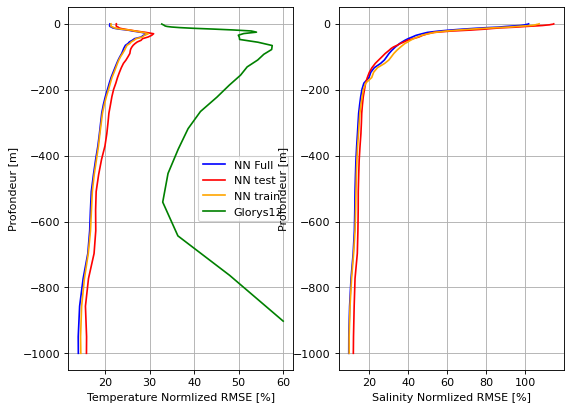

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')



ax[0].plot((d_full['rmse_T_model'].mean(axis=0)/(d_full['TEMP'].std({'N_PROF'}).mean(axis=0)))*100, -d_full['DEPTH'], label='NN Full', c="blue")
ax[0].plot((d_test['rmse_T_model'].mean(axis=0)/(d_test['TEMP'].std({'N_PROF'}).mean(axis=0)))*100,  -d_full['DEPTH'], label='NN test', c="red")
ax[0].plot((d_train['rmse_T_model'].mean(axis=0)/(d_train['TEMP'].std({'N_PROF'}).mean(axis=0)))*100, -d_full['DEPTH'], label='NN train', c="orange")

ax[0].plot(list_final, -x_glo['depth'], label='Glorys12', c="green")


ax[0].set_xlabel('Temperature Normlized RMSE [%]')
ax[0].set_ylabel('Profondeur [m]')

ax[1].set_xlabel('Salinity Normlized RMSE [%]')
ax[1].set_ylabel('Profondeur [m]')

ax[1].plot((d_full['rmse_S_model'].mean(axis=0)/(d_full['PSAL'].std({'N_PROF'}).mean(axis=0)))*100, -d_full['DEPTH'], label='NN Full', c="blue")
ax[1].plot((d_test['rmse_S_model'].mean(axis=0)/(d_test['PSAL'].std({'N_PROF'}).mean(axis=0)))*100, -d_full['DEPTH'], label='NN test', c="red")
ax[1].plot((d_train['rmse_S_model'].mean(axis=0)/(d_test['PSAL'].std({'N_PROF'}).mean(axis=0)))*100, -d_full['DEPTH'], label='NN train', c="orange")

#ax[1].plot(list_final_salinity, -x_glo['depth'], label='Glorys12', c="green")


ax[0].grid()
ax[1].grid()
leg = ax[0].legend();


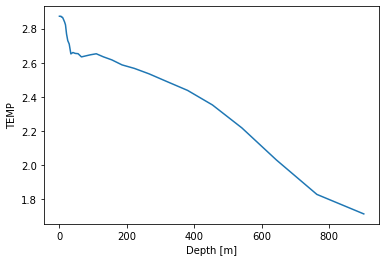

In [28]:
tmp_ds['TEMP'].std({'N_PROF'}).plot()

# 